# Importing modules

In [1]:
# !pip install gensim
# !pip install nltk
# !pip install transformers torch pytesseract

# import fasttext
import sqlite3
import pandas as pd
pd.set_option('display.max_columns', None)
import string
import regex as re
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Input

from transformers import CamembertModel, CamembertTokenizer, pipeline, CamembertConfig
from transformers import AutoConfig, AutoModel, AutoTokenizer,TFAutoModel,AutoModelForMaskedLM

import matplotlib.pyplot as plt
import plotly.express as px

/Users/guillaumevelter/.pyenv/versions/3.10.6/envs/etreprof-lewagon-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading database

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#connect =sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/contents_v3.db')
connect =sqlite3.connect('data/contents_v3.db')
cursor = connect.cursor()
cursor.execute("SELECT * FROM contents")
contents = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
contents_as_list = [list(row) for row in contents]
df = pd.DataFrame(contents_as_list, columns=column_names)
df.head()

,id,title,type,markdown,categories,niveaux,auteur,categorie,categorie_principale,created_at,date_debut,description,difficulte,downloads_count,duree_heures,duree_minutes,duree_secondes,etat,json_categories,json_centre_interet,json_niveau,json_niveau_detail,landing_url,nb_abonnes,nb_commentaires,nb_presents,niveau,page_view_count,published_at,score_downvote,score_upvote,source_url,sous_categorie,statut,titre,updated_at,url,transition_ecologique,sante_mentale,ecole_inclusive,cps,reussite_tous_eleves
0,371,Utiliser l'appel en maternelle comme situation...,article,"[Un rituel est une activité répétée, régulière...","['Apprendre à vivre ensemble', 'Sélection de r...","['TPS', 'PS', 'MS', 'GS', 'Maternelle']",ecole christine,Sélection de ressources mathématiques,None,None,None,None,None,NaN,NaN,22.0,1278.0,publie,"[""Apprendre à vivre ensemble"", ""Sélection de r...",None,"[""TPS"", ""PS"", ""MS"", ""GS"", ""Maternelle""]",None,None,NaN,1.0,NaN,None,3811.0,2017-04-13 11:32:23,2.0,43.0,https://www.youtube.com/channel/UChgoVdAQWK-t_...,None,None,None,2023-06-22 16:41:33,https://www.youtube.com/watch?v=7quHGbemeiM,0,0,0,0,0
1,45,Gestion des émotions en classe pour l'enseigna...,article,Une vidéo pour comprendre nos réactions de str...,['Gérer mes émotions'],[],TEDx Talks,Gérer mes émotions,None,None,None,None,None,NaN,NaN,16.0,935.0,publie,"[""Gérer mes émotions""]",None,[],None,None,NaN,0.0,NaN,None,453.0,2017-04-23 16:40:09,0.0,2.0,https://www.youtube.com/channel/UCsT0YIqwnpJCM...,None,None,None,2023-07-10 10:23:40,https://www.youtube.com/watch?v=CNSylSf02WU,0,0,0,0,0
2,597,Comment faciliter la mémorisation ? L'impact d...,article,"Dans cette vidéo, vous allez découvrir l'impac...",['Apprendre à apprendre'],[],None,Apprendre à apprendre,None,None,None,None,None,NaN,NaN,2.0,108.0,publie,"[""Apprendre à apprendre""]",None,[],None,None,NaN,0.0,NaN,None,448.0,2017-04-27 15:10:26,0.0,5.0,https://www.youtube.com/channel/UCQqxRKXeHj9BC...,None,None,None,2024-01-15 15:29:14,https://www.youtube.com/watch?v=Ya7nbydLoUo,0,1,0,0,0
3,625,Les différents types de mémoire,article,"\n\nLa mémoire nous permet d’encoder, de stock...","['Apprendre à apprendre', 'Enseigner avec les ...","['TPS', 'PS', 'MS', 'GS', 'Maternelle', 'CP', ...",C'est pas sorcier,Enseigner avec les neurosciences,None,None,None,None,None,NaN,NaN,6.0,NaN,publie,"[""Apprendre à apprendre"", ""Enseigner avec les ...",None,"[""TPS"", ""PS"", ""MS"", ""GS"", ""Maternelle"", ""CP"", ...",None,None,NaN,2.0,NaN,None,3430.0,2017-04-19 15:12:38,1.0,12.0,None,None,None,None,2024-03-29 09:53:28,https://www.youtube.com/watch?v=Crh3MtpVZxM,0,0,0,0,1
4,542,Lire à partir de tapuscrits au CP,article,\n\nDevenir lecteur est une étape importante d...,"['Construire des séances', 'Travailler en atel...","['GS', 'CP', 'CE1']",https://lecycle2.wordpress.com,Sélection de ressources français,None,None,None,None,None,NaN,NaN,7.0,NaN,publie,"[""Construire des séances"", ""Travailler en atel...",None,"[""GS"", ""CP"", ""CE1""]",None,None,NaN,7.0,NaN,None,22709.0,2024-11-27 12:08:44,26.0,244.0,None,None,None,None,2024-12-02 11:05:32,https://lecycle2.wordpress.com/2016/04/08/tapu...,0,0,0,0,0


# Cleaning text from markdown features

In [3]:
def clean_text(text):
    # text = text.lower()
    text = re.sub(r'http\S+', ' ', text) # Remove email addresses
    text = re.sub(r'<.*?>', ' ', text) # Remove Markdown symbols
    text = re.sub(r'[*#_`~>]', '', text)  # Remove Markdown symbols
    text = re.sub(r'\s+', ' ', text)  # Normalize spaces
    text = text.replace('\n', ' ')
    text = text.replace('•', ' ')
    text = text.replace('●', ' ')
    text = text.replace('○', ' ')
    text = text.replace('#', ' ')
    text = text.replace('[', ' ')
    text = text.replace(']', ' ')
    text = text.replace('*', ' ')
    # text = text.replace('«', ' ')
    # text = text.replace('»', ' ')
    # text = text.replace("'", ' ')
    # text = ''.join(char for char in text if not char.isdigit())
    # for item in string.punctuation:
    #     text = text.replace(item,' ')
    text = text.replace('CC BY-NC-SA 4.0 DEED', '')
    # text = text.replace('…', '')
    return text.strip()

In [4]:
cleaned_df = df[df['markdown'].notnull()] # Keep rows with content

In [5]:
cleaned_df['cleaned text'] = cleaned_df['markdown'].apply(clean_text) # Cleaning content and storing it in a 'cleaned text' column
cleaned_df.head()

/var/folders/73/rmpts_0n0r56j1tr5qg14v340000gn/T/ipykernel_29412/3486315577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cleaned text'] = cleaned_df['markdown'].apply(clean_text) # Cleaning content and storing it in a 'cleaned text' column


,id,title,type,markdown,categories,niveaux,auteur,categorie,categorie_principale,created_at,date_debut,description,difficulte,downloads_count,duree_heures,duree_minutes,duree_secondes,etat,json_categories,json_centre_interet,json_niveau,json_niveau_detail,landing_url,nb_abonnes,nb_commentaires,nb_presents,niveau,page_view_count,published_at,score_downvote,score_upvote,source_url,sous_categorie,statut,titre,updated_at,url,transition_ecologique,sante_mentale,ecole_inclusive,cps,reussite_tous_eleves,cleaned text
0,371,Utiliser l'appel en maternelle comme situation...,article,"[Un rituel est une activité répétée, régulière...","['Apprendre à vivre ensemble', 'Sélection de r...","['TPS', 'PS', 'MS', 'GS', 'Maternelle']",ecole christine,Sélection de ressources mathématiques,None,None,None,None,None,NaN,NaN,22.0,1278.0,publie,"[""Apprendre à vivre ensemble"", ""Sélection de r...",None,"[""TPS"", ""PS"", ""MS"", ""GS"", ""Maternelle""]",None,None,NaN,1.0,NaN,None,3811.0,2017-04-13 11:32:23,2.0,43.0,https://www.youtube.com/channel/UChgoVdAQWK-t_...,None,None,None,2023-06-22 16:41:33,https://www.youtube.com/watch?v=7quHGbemeiM,0,0,0,0,0,"Un rituel est une activité répétée, régulière ..."
1,45,Gestion des émotions en classe pour l'enseigna...,article,Une vidéo pour comprendre nos réactions de str...,['Gérer mes émotions'],[],TEDx Talks,Gérer mes émotions,None,None,None,None,None,NaN,NaN,16.0,935.0,publie,"[""Gérer mes émotions""]",None,[],None,None,NaN,0.0,NaN,None,453.0,2017-04-23 16:40:09,0.0,2.0,https://www.youtube.com/channel/UCsT0YIqwnpJCM...,None,None,None,2023-07-10 10:23:40,https://www.youtube.com/watch?v=CNSylSf02WU,0,0,0,0,0,Une vidéo pour comprendre nos réactions de str...
2,597,Comment faciliter la mémorisation ? L'impact d...,article,"Dans cette vidéo, vous allez découvrir l'impac...",['Apprendre à apprendre'],[],None,Apprendre à apprendre,None,None,None,None,None,NaN,NaN,2.0,108.0,publie,"[""Apprendre à apprendre""]",None,[],None,None,NaN,0.0,NaN,None,448.0,2017-04-27 15:10:26,0.0,5.0,https://www.youtube.com/channel/UCQqxRKXeHj9BC...,None,None,None,2024-01-15 15:29:14,https://www.youtube.com/watch?v=Ya7nbydLoUo,0,1,0,0,0,"Dans cette vidéo, vous allez découvrir l'impac..."
3,625,Les différents types de mémoire,article,"\n\nLa mémoire nous permet d’encoder, de stock...","['Apprendre à apprendre', 'Enseigner avec les ...","['TPS', 'PS', 'MS', 'GS', 'Maternelle', 'CP', ...",C'est pas sorcier,Enseigner avec les neurosciences,None,None,None,None,None,NaN,NaN,6.0,NaN,publie,"[""Apprendre à apprendre"", ""Enseigner avec les ...",None,"[""TPS"", ""PS"", ""MS"", ""GS"", ""Maternelle"", ""CP"", ...",None,None,NaN,2.0,NaN,None,3430.0,2017-04-19 15:12:38,1.0,12.0,None,None,None,None,2024-03-29 09:53:28,https://www.youtube.com/watch?v=Crh3MtpVZxM,0,0,0,0,1,"La mémoire nous permet d’encoder, de stocker e..."
4,542,Lire à partir de tapuscrits au CP,article,\n\nDevenir lecteur est une étape importante d...,"['Construire des séances', 'Travailler en atel...","['GS', 'CP', 'CE1']",https://lecycle2.wordpress.com,Sélection de ressources français,None,None,None,None,None,NaN,NaN,7.0,NaN,publie,"[""Construire des séances"", ""Travailler en atel...",None,"[""GS"", ""CP"", ""CE1""]",None,None,NaN,7.0,NaN,None,22709.0,2024-11-27 12:08:44,26.0,244.0,None,None,None,None,2024-12-02 11:05:32,https://lecycle2.wordpress.com/2016/04/08/tapu...,0,0,0,0,0,Devenir lecteur est une étape importante dans ...


In [6]:
cleaned_df['cleaned text length'] = cleaned_df['cleaned text'].apply(len) # Counting the number of characters for each cleaned content

/var/folders/73/rmpts_0n0r56j1tr5qg14v340000gn/T/ipykernel_29412/3504807721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cleaned text length'] = cleaned_df['cleaned text'].apply(len) # Counting the number of characters for each cleaned content


# Selecting relevant (longest) contents and features

In [7]:
# Removing fiches d'activité and sequences that have not much content
longest_content_df = cleaned_df[((cleaned_df['cleaned text length'] > 1000) & (cleaned_df['type'] == 'fiche_activite')) |
                                ((cleaned_df['cleaned text length'] > 1000) & (cleaned_df['type'] == 'sequence')) |
                                ((cleaned_df['type'] != 'sequence') & (cleaned_df['type'] != 'fiche_activite'))]

In [8]:
longest_content_df['type'].value_counts()

type
article           812
fiche_outils      583
fiche_activite    193
tuto               83
podcast            46
guide_pratique     21
sequence            9
Name: count, dtype: int64

In [9]:
selected_columns = ['id','title','type','markdown','categories','niveaux',
                    'categorie','categorie_principale','page_view_count','transition_ecologique',
                    'sante_mentale','ecole_inclusive','cps','reussite_tous_eleves','cleaned text','cleaned text length']

longest_content_df = longest_content_df[selected_columns]

# Selecting contents with priority challenges

In [10]:
longest_content_priority_challenges_df = longest_content_df[(longest_content_df["transition_ecologique"] == 1) |
                                    (longest_content_df["sante_mentale"] == 1) |
                                    (longest_content_df["ecole_inclusive"] == 1) |
                                    (longest_content_df["cps"]==1)|
                                    (longest_content_df["reussite_tous_eleves"]==1)]

longest_content_without_priority_challenges_df = longest_content_df[(longest_content_df["transition_ecologique"] == 0) &
                                    (longest_content_df["sante_mentale"] == 0) &
                                    (longest_content_df["ecole_inclusive"] == 0) &
                                    (longest_content_df["cps"]==0)&
                                    (longest_content_df["reussite_tous_eleves"]==0)]


In [11]:
longest_content_priority_challenges_df = longest_content_priority_challenges_df[selected_columns]

longest_content_without_priority_challenges_df= longest_content_without_priority_challenges_df[selected_columns]

In [12]:
longest_content_priority_challenges_df[['transition_ecologique',	'sante_mentale',	'ecole_inclusive',	'cps',	'reussite_tous_eleves']].value_counts()

transition_ecologique  sante_mentale  ecole_inclusive  cps  reussite_tous_eleves
0                      0              0                0    1                       140
                                                       1    0                        56
                                      1                0    0                        56
1                      0              0                0    0                        50
0                      1              0                0    0                        22
Name: count, dtype: int64

In [13]:
# longest_content_unique_priority_challenges_df = longest_content_priority_challenges_df[
#                                     ((longest_content_priority_challenges_df["transition_ecologique"] == 1) &
#                                         (longest_content_priority_challenges_df["sante_mentale"] == 0)&
#                                         (longest_content_priority_challenges_df["ecole_inclusive"] == 0) &
#                                         (longest_content_priority_challenges_df["cps"]==0)&
#                                         (longest_content_priority_challenges_df["reussite_tous_eleves"]==0)) |

#                                     ((longest_content_priority_challenges_df["transition_ecologique"] == 0) &
#                                         (longest_content_priority_challenges_df["sante_mentale"] == 1)&
#                                         (longest_content_priority_challenges_df["ecole_inclusive"] == 0) &
#                                         (longest_content_priority_challenges_df["cps"]==0)&
#                                         (longest_content_priority_challenges_df["reussite_tous_eleves"]==0)) |

#                                     ((longest_content_priority_challenges_df["transition_ecologique"] == 0) &
#                                         (longest_content_priority_challenges_df["sante_mentale"] == 0)&
#                                         (longest_content_priority_challenges_df["ecole_inclusive"] == 1) &
#                                         (longest_content_priority_challenges_df["cps"]==0)&
#                                         (longest_content_priority_challenges_df["reussite_tous_eleves"]==0)) |

#                                     ((longest_content_priority_challenges_df["transition_ecologique"] == 0) &
#                                         (longest_content_priority_challenges_df["sante_mentale"] == 0)&
#                                         (longest_content_priority_challenges_df["ecole_inclusive"] == 0) &
#                                         (longest_content_priority_challenges_df["cps"]==1)&
#                                         (longest_content_priority_challenges_df["reussite_tous_eleves"]==0)) |

#                                     ((longest_content_priority_challenges_df["transition_ecologique"] == 0) &
#                                         (longest_content_priority_challenges_df["sante_mentale"] == 0)&
#                                         (longest_content_priority_challenges_df["ecole_inclusive"] == 0) &
#                                         (longest_content_priority_challenges_df["cps"]==0)&
#                                         (longest_content_priority_challenges_df["reussite_tous_eleves"]==1))
#                                     ]
# longest_content_unique_priority_challenges_df[['transition_ecologique',	'sante_mentale',	'ecole_inclusive',	'cps',	'reussite_tous_eleves']].value_counts()

In [14]:
# longest_content_unique_priority_challenges_df.info()

# Embedding with BERT

In [15]:
# Quick check on the cleaned text
for index,content in enumerate(longest_content_df['cleaned text'].iloc[10:18]):
        print(f'NUMBER {index}')
        print(f'        {content}')
        print()

NUMBER 0
        CYCLE 2 CP CE1 CE2 Fiche rédigée par Emmanuelle DENAND @emmadarcyyy Matériel: - ​ Images en couleurs illustrant une petite histoire (3 images par série) - ​ Blocs de phrases à associer (1 par image) - ​ Grille de contrôle élève - ​ Fiche de référence pour l’auto-correction - ​ Plaques plastifiées pour le positionnement chronologique Préparation : Imprimer, plastifier et numéroter les images au verso. Imprimer et découper les blocs de phrases (2 niveaux si différenciation). Imprimer la grille de contrôle et la fiche de référence. Préparer les plaques de positionnement. Ce jeu de manipulation d’images permet d’approcher des concepts de temporalité et de déroulement logique en lien avec l’écrit. Pour des élèves qui manquent de repères spatio-temporels, il permet de poser un cadre ludique à la validation rapide. C’est une activité qui peut-être ritualisée et qui amène à l’autonomie. Plusieurs niveaux d’adaptation sont possibles en fonction des besoins observés. Activité de

In [16]:
# Choosing a BERT equivalent model for french langage : camembertav2 - Importing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("almanach/camembertav2-base")

### Loading the model and making it work

In [17]:
sentence = "J'aime le camembert!"
encoded_sentence = tokenizer.encode(sentence,return_tensors='tf')
encoded_sentence

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[   1, 5655, 6976, 4722, 7550, 5209, 8344,    8,    2]],
      dtype=int32)>

In [18]:
# Choosing a BERT equivalent model for french langage : camembertav2 - Importing the model
camembert_model = TFAutoModel.from_pretrained("almanach/camembertav2-base",from_pt=True)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2Model: ['embeddings.position_ids']
- This IS expected if you are initializing TFDebertaV2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


In [19]:
camembert_model.num_parameters()

110616576

In [20]:
# Testing what camembert outputs => vecorization of each token in 768 dimensions
output_1 = camembert_model(encoded_sentence)

In [21]:
output_1

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[ 0.7059433 ,  0.54172546, -0.4635562 , ..., -0.36027578,
         -0.3443741 ,  0.15944433],
        [ 0.20999914,  0.4364571 , -0.09006187, ...,  0.09819807,
          0.15211216, -0.3242597 ],
        [ 0.0757838 ,  0.17937246,  0.34092176, ...,  0.16791394,
         -0.29952097,  0.2729798 ],
        ...,
        [ 0.06955831, -0.13345769,  0.19709572, ..., -0.47041708,
          0.11060224, -0.17384115],
        [ 0.1468478 , -0.22659281, -0.07110845, ..., -0.36838725,
          0.06805591, -0.38173443],
        [ 0.78475   ,  0.02341565, -0.17277642, ..., -0.7120459 ,
         -0.15379938, -0.2204709 ]]], dtype=float32)>, hidden_states=None, attentions=None)

In [22]:
output_1.last_hidden_state.shape

TensorShape([1, 9, 768])

In [23]:
CLS = output_1.last_hidden_state[:, 0, :]

### Testing the model on a large sentence

<Axes: ylabel='Frequency'>

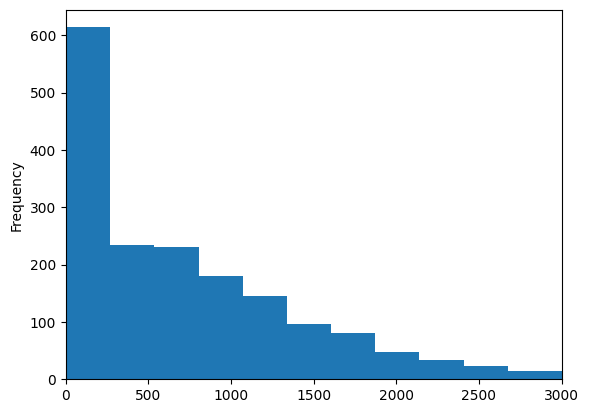

In [24]:
# Distribution of the token number of the corpus => We will be forced to truncate all the contents to 250 tokens max, otherwise it will crashed COLAB because of the RAM
longest_content_df['tokenized text'] = longest_content_df['cleaned text'].apply(tokenizer.tokenize)
longest_content_df['number tokens'] = longest_content_df['tokenized text'].apply(len)
longest_content_df['number tokens'].plot.hist(bins=40, xlim=(0,3000))

In [25]:
sentence = "CYCLE 2 CP CE1 CE2        Jeu des phrases à découper      Fiche rédigée par Emmanuelle DENAND       @emma_darcyyy       Matériel   :     - ​ Cartes plastifiées recto-verso : phrases à  segmenter / phrases corrigées      - ​ Grille de copie des phrases travaillées      - ​ Gammes de lecture des mots outils rencontrés     Préparation :    Imprimer, plastifier et classer les cartes .   Cette activité s’intègre dans une démarche de compréhension fine du fonctionnement de la  phrase, en lien avec l’étude de la langue (syntaxe, lexique) et la construction du sens. Elle   permet d’aborder la segmentation en mots et la reconnaissance des unités lexicales. Elle est   très utile pour travailler le sens de l’écrit en général et celui de la phrase en particulier. Les   élèves qui ont tendance à sous-segmenter ou à sur-segmenter peuvent travailler l’unité-mot   dans son entité de sens et dans le code orthographique. Les images viennent soutenir la   compréhension de la phrase pour éviter les malentendus socio-cognitifs qui peuvent induire   en erreur.     Activité de l’élève :        ​     Identifier les mots dans une phrase continue.       ​     Séparer les mots   collés dans la phrase (avec un feutre effaçable).      ​     Contrôler son travail   avec la fiche auto-corrective.     ​     Recopier la phrase   obtenue sur la fiche.     ​     Présenter à l’adulte  , pour la validation finale.     Points d’attention :        - ​ Se questionner sur le sens des mots et sur le sens de la phrase     - ​ S’appuyer sur les indices syntaxiques et lexicaux pour segmenter.     - ​ Prendre appui sur les mots outils connus pour stabiliser les repérages.     - ​    Pour aller plus loin :   Extraire les mots outils des phrases proposées, les lister, les classer, les lire (fluence), les copier, les écrire en dictée, les réinvestir dans d’autres phrases lors de productions d’écrits ultérieures.  Créer son propre jeu de segmentation et le présenter à d’autres classes. S’inspirer des thèmes travaillés en classe et dans l’école chaque année pour produire des phrases qui réinvestissent le vocabulaire travaillé ainsi que d’autres mots outils        CYCLE 2 CP CE1 CE2      Compétences   :  |CP|CE1|CE2| |---|---|---| |   | ​ Se repérer dans la phrase simple  ​ Identifer les mots et groupes de mots  ​ Mémoriser des mots invariables  ​ S’initier à l’orthographe lexicale| ​ Se repérer dans la phrase simple  ​ Identifer les mots et groupes de mots  ​ Mémoriser des mots invariables  ​ S’initier à l’orthographe lexicale|      Notes personnelles :      - Cette fiche est partageable avec attribution."


In [26]:
tokenized_sentence = tokenizer.tokenize(sentence)
tokenized_sentence

['C',
 '##Y',
 '##CL',
 '##E',
 '2',
 'CP',
 'CE',
 '##1',
 'CE',
 '##2',
 '    ',
 '    ',
 'Jeu',
 'des',
 'phrases',
 'à',
 'découper',
 '    ',
 '  ',
 'Fiche',
 'rédigé',
 '##e',
 'par',
 'Emmanuelle',
 'DE',
 '##NA',
 '##N',
 '##D',
 '    ',
 '   ',
 '@',
 'emm',
 '##a',
 '_',
 'dar',
 '##cy',
 '##y',
 '##y',
 '    ',
 '   ',
 'Matériel',
 '   ',
 ':',
 '    ',
 '-',
 '  ',
 'Cartes',
 'plas',
 '##tif',
 '##iées',
 'rect',
 '##o',
 '-',
 'vers',
 '##o',
 ':',
 'phrases',
 'à',
 '  ',
 'segment',
 '##er',
 '/',
 'phrases',
 'corrig',
 '##ées',
 '    ',
 '  ',
 '-',
 '  ',
 'Gri',
 '##lle',
 'de',
 'copie',
 'des',
 'phrases',
 'travaillé',
 '##es',
 '    ',
 '  ',
 '-',
 '  ',
 'Gam',
 '##mes',
 'de',
 'lecture',
 'des',
 'mots',
 'outils',
 'rencontrés',
 '    ',
 'Préparation',
 ':',
 '    ',
 'Imprimer',
 ',',
 'plas',
 '##tif',
 '##ier',
 'et',
 'classer',
 'les',
 'cartes',
 '.',
 '   ',
 'Cette',
 'activité',
 's’',
 'intègre',
 'dans',
 'une',
 'démarche',
 'de',
 'compréhe

In [27]:
len(tokenized_sentence)

615

In [28]:
longest_content_df['number tokens'].argmax()

np.int64(1150)

In [29]:
for index, content in enumerate(longest_content_df['cleaned text'].iloc[0:8]):
    print(f'NUMBER {index}')
    token_length = longest_content_df['number tokens'].iloc[index]
    print(f'Token length: {token_length}')
    print(f'        {content}')
    print()

NUMBER 0
Token length: 253
        Un rituel est une activité répétée, régulière et de courte durée ( Ils doivent échapper au piège de la routine et qui génère de l'ennui. Ils sont et doivent être issus d'une réflexion pédagogique et doivent faire l'objet d'un apprentissage. En classe de maternelle, les rituels sont nombreux et nous devons veiller à ce qu'ils soient porteurs de sens et d'apprentissage pour ne pas perdre leur objectif. Les rituels pour assurer la continuité du cadre de notre classe Ils structurent le temps et ont des objectifs divers pour : - tisser du lien entre les apprentissages ; - symboliser l'entrée et la sortie de classe ; - formaliser les apprentissages avec des échanges didactiques ; - ouvrir ou fermer sa semaine, sa période, etc. ; - assurer des transitions entre les activités ; - … Les rituels permettent d'installer des automatismes rassurants si tant est qu'ils sont porteurs de sens et sont évolutifs et réinterrogés régulièrement sur leur fond et leur forme.

In [30]:
max_length = 500
encoded_sentence = tokenizer.encode(longest_content_df['cleaned text'].iloc[0],is_split_into_words=False,return_tensors='tf',padding=True, truncation=True,max_length=max_length)
encoded_sentence.shape

TensorShape([1, 255])

In [31]:
encoded_sentence

<tf.Tensor: shape=(1, 255), dtype=int32, numpy=
array([[    1,  5035, 23033,  4750,  4764,  6572, 24761,  3205,    19,
        14360,  4718,  4702, 11985,  7584,    15,  6063,  6957, 15615,
         4745, 22211,  4702,  4715, 20594,  4718,  4795, 22783,  4702,
         4736, 26868,    21,  6063,  4871,  4718,  6957,  4959, 12249,
         4742,  4764, 10533, 14245,  4718,  6957,  5043,  4736,  6335,
         4742,  4744,  9669,    21,  4925,  6644,  4702, 15555,    19,
         4733, 28592,  4871,  6191,  4718,  4936, 13365, 17950,   177,
         4839,  4902,  5208,  7852, 19496,  4702,  6064,  4718,  4742,
         9669,  4760,  4856,  4801,  9157,  5071,  7220,    21,  4897,
        28592,  4760,  7596,  4715, 16294,  4755,  6213,  4702,  5223,
         6644,  6063,  7869,  4701,  4722,  5217,  4718,  4982,  4730,
         8806,  6606,  4760,    33,    20,  8610,  4703,  4755,  7378,
         4948,  4733, 26051,    34,    20, 18369,  6793,  4736,  7288,
         4718,  4715,  7325, 

In [32]:
output_1 = camembert_model.predict(encoded_sentence)

1/1 [==============================] - 3s 3s/step


In [33]:
output_1.last_hidden_state.shape

(1, 255, 768)

### Embedding the full dataset (not used for the time being - effort put on content with priority challenges)

In [34]:
# embedded_contents = tokenizer(longest_content_df['cleaned text'].tolist(),is_split_into_words=False,return_tensors='tf',padding=True, truncation=True,max_length=max_length)
# embedded_contents['input_ids'][:250]

In [35]:
# embedded_contents

In [36]:
# embedded_contents['input_ids']

In [37]:
# camembert_embeddings = camembert_model(embedded_contents['input_ids'][:50])

In [38]:
# camembert_embeddings.last_hidden_state[:,0,:]

### Embedding the content with priority challenges

In [39]:
max_length = 250  # We have to truncate all the contents to 250 tokens max, otherwise it will crashed COLAB because of the RAM.
                  # 500 can work but then embedding takes a lot of time since you have to woRK with smaller batch sizes (See Embedding by batches)
embedded_contents = tokenizer(longest_content_priority_challenges_df['cleaned text'].tolist(),is_split_into_words=False,return_tensors='tf',padding=True, truncation=True,max_length=max_length)
embedded_contents['input_ids']

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


<tf.Tensor: shape=(324, 250), dtype=int32, numpy=
array([[    1,  5356,  4980, ...,     0,     0,     0],
       [    1,  4858,  8658, ...,  4942,  5059,     2],
       [    1,   125,  4905, ...,    19,  4782,     2],
       ...,
       [    1, 20473,  5067, ...,     0,     0,     0],
       [    1, 18132, 15968, ...,     0,     0,     0],
       [    1, 18132, 15968, ...,     0,     0,     0]], dtype=int32)>

#### Embedding by batches

In [40]:
batch_size = 50
camembert_embeddings = []
number_of_content = 300
sentences = list(longest_content_priority_challenges_df['cleaned text'].iloc[:number_of_content])

for i in range(0, len(sentences), batch_size):
    print(f"Embedding batch {i/50+1} / {number_of_content/batch_size}")
    batch = sentences[i:i+batch_size]
    encoded = tokenizer(batch,is_split_into_words=False,return_tensors='tf',padding=True, truncation=True,max_length=max_length)
    outputs = camembert_model(**encoded)
    batch_embeddings = outputs.last_hidden_state[:,0,:]  # Retaining only the [CLS] embeddings
    camembert_embeddings.append(batch_embeddings)

final_embeddings = tf.concat(camembert_embeddings, axis=0)

Embedding batch 1.0 / 6.0
Embedding batch 2.0 / 6.0
Embedding batch 3.0 / 6.0
Embedding batch 4.0 / 6.0
Embedding batch 5.0 / 6.0
Embedding batch 6.0 / 6.0


In [41]:
# np.save('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_embeddings.npy', final_embeddings.numpy())

In [42]:
# loaded_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_embeddings.npy')
# loaded_embeddings

In [43]:
# loaded_embeddings.shape

In [44]:
# with open('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_embeddings_250.pkl', 'wb') as f:
#     pickle.dump(final_embeddings, f)

In [45]:
# with open('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_embeddings.pkl', 'rb') as f:
#     loaded_pkl_embeddings = pickle.load(f)

In [46]:
# final_embeddings = loaded_pkl_embeddings

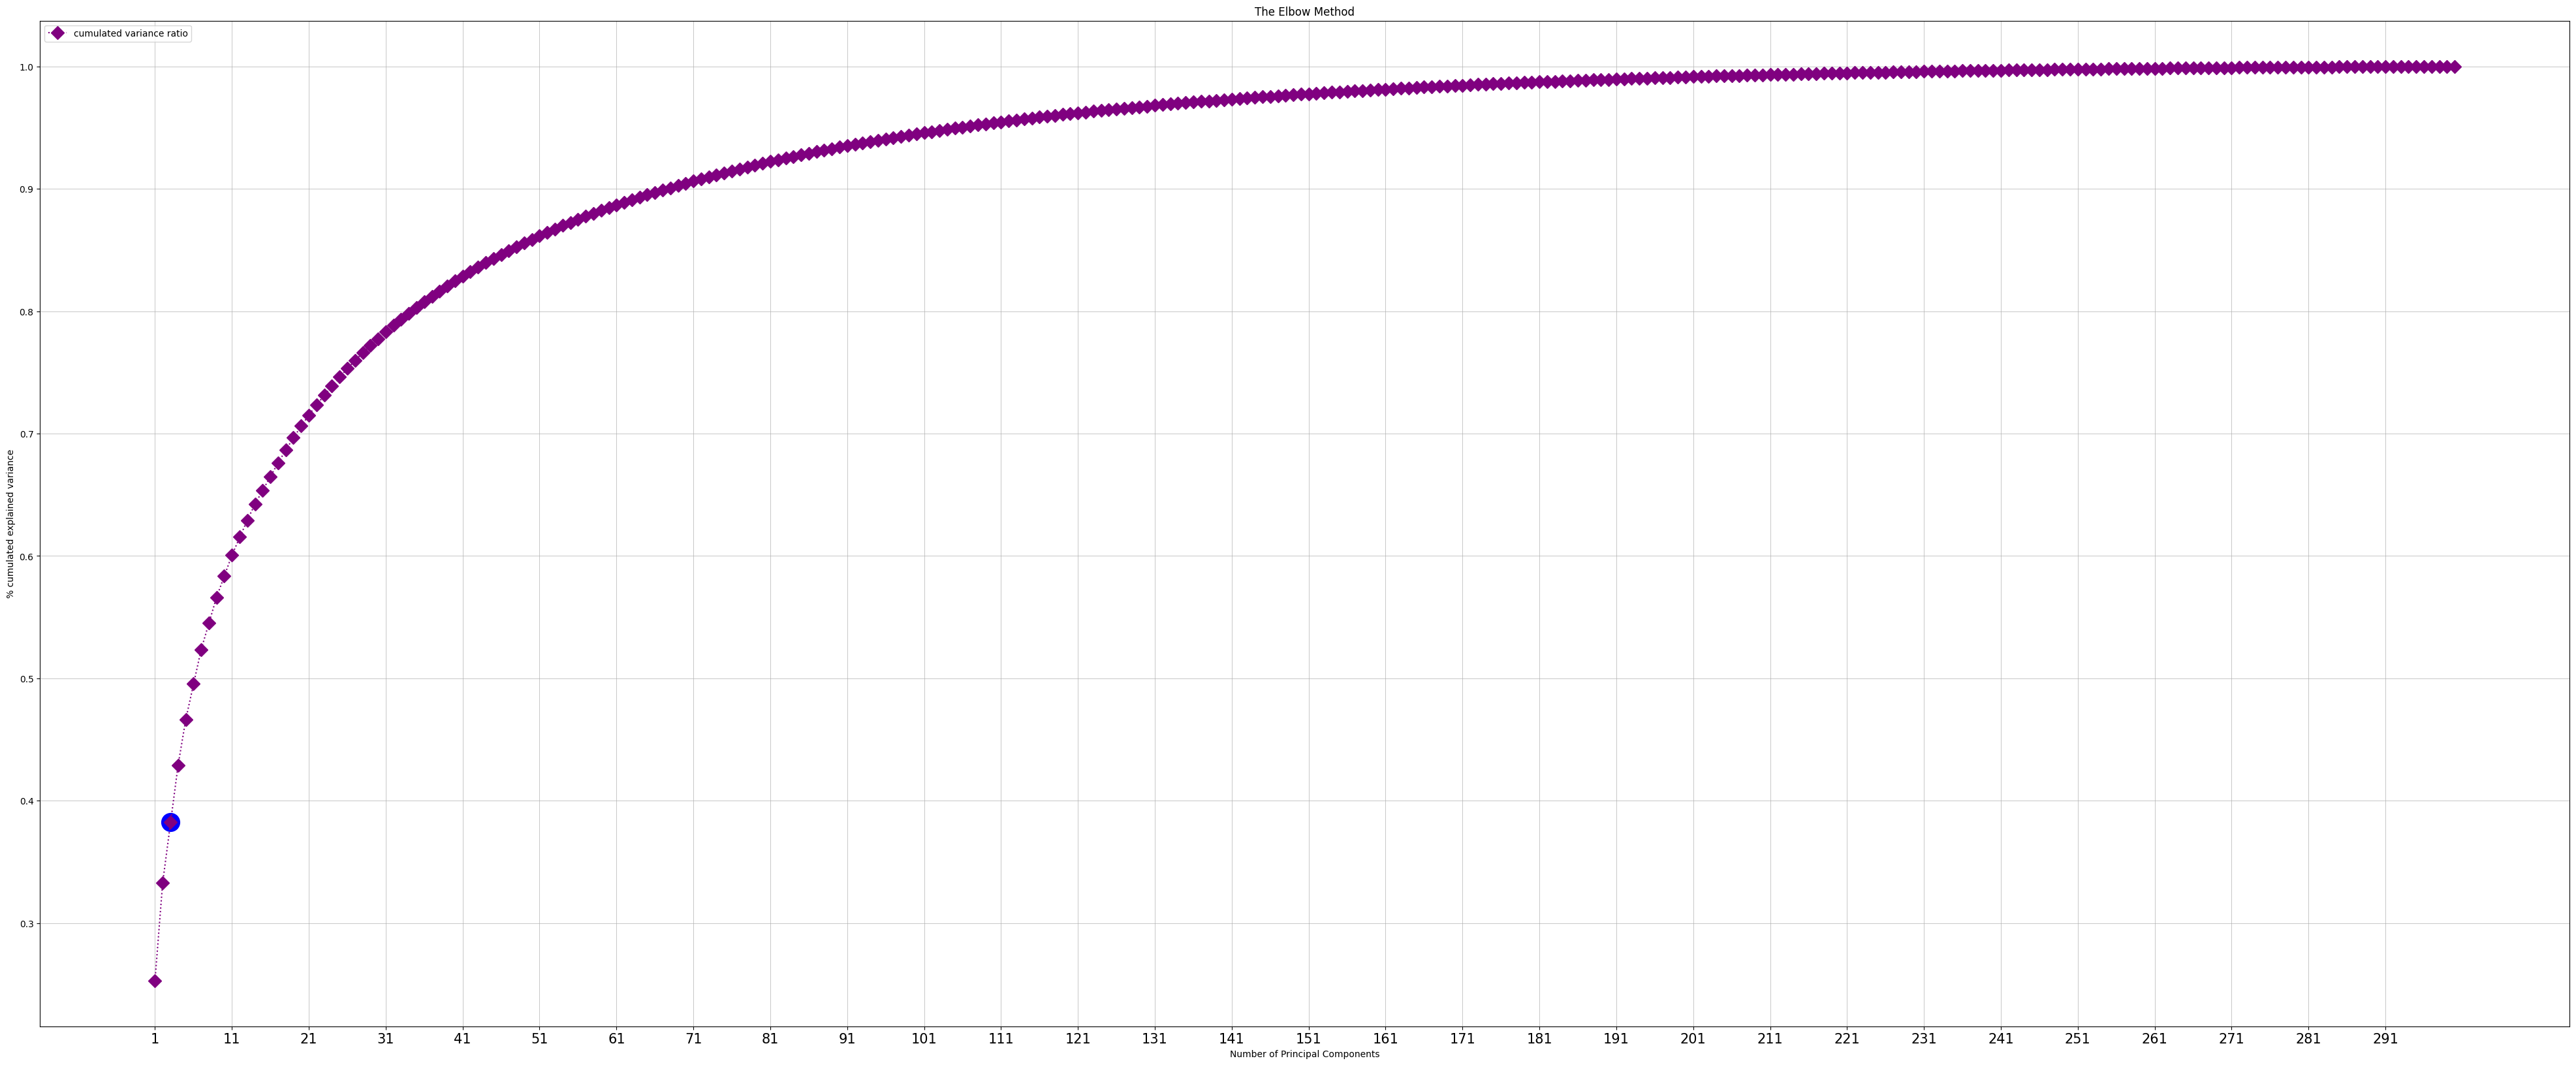

In [47]:
# Reducing embedding dimensions with PCA (help for model convergence)

pca = PCA()
pca.fit(final_embeddings)
X_embeddings_pca = pca.transform(final_embeddings)
X_embeddings_pca_df = pd.DataFrame(X_embeddings_pca)

with plt.style.context('fast'):
    # figsize
    plt.figure(figsize=(50,20))
    # getting axes
    ax = plt.gca()
    # plotting
    explained_variance_ratio_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,explained_variance_ratio_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,explained_variance_ratio_cumulated,label="cumulated variance ratio",color="purple",linestyle=":",marker="D",markersize=10)
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_xticks(x_axis_ticks[::10])
    ax.scatter(3,explained_variance_ratio_cumulated[3-1],c='blue',s=400)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

In [48]:
# X = final_embeddings.numpy()
X = X_embeddings_pca
y = longest_content_priority_challenges_df[['transition_ecologique','sante_mentale','ecole_inclusive','cps','reussite_tous_eleves']].iloc[:number_of_content]

In [49]:
y['label'] = y.idxmax(axis=1).map({'transition_ecologique':0,
                                    'sante_mentale':1,
                                    'ecole_inclusive':2,
                                    'cps':3,
                                    'reussite_tous_eleves':4
                                    })

In [50]:
# Plotting the CLS vectors of each content with priority challenge labels in the 3D space of the 3 most important Principal Components
fig = px.scatter_3d(X_embeddings_pca_df,
                    x = 0,
                    y = 1,
                    z = 2,
                    color=y['label'],opacity=0.7, width=500, height=500
           )
fig.show()

In [51]:
y = y.drop(columns=['label'])
y = y.to_numpy()

#### Train / Test splitting X (content [CLS] embeddings) and y (priority challenge labels)

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [53]:
X_train.shape

(240, 300)

In [54]:
y_train.shape

(240, 5)

### Training a dense Neural Network from CAMEMBERT embeddings

##### Creating the NN model for classification task and running it

In [55]:
es = EarlyStopping(patience = 20, restore_best_weights=True)

optimizer = Adam(
    learning_rate=0.0005,
    beta_1=0.90,
    beta_2=0.999,
    epsilon=1e-07,
)

In [56]:
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
# model.add(layers.Dense(512,activation='relu'))
# model.add(Dropout(0.2))
model.add(layers.Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(Dropout(0.5))
# model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [57]:
model.fit(X_train,y_train,validation_split=0.2,batch_size = 32, epochs=1000, callbacks=es)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1891 - loss: 1.6816 - val_accuracy: 0.2708 - val_loss: 1.5947
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2936 - loss: 1.5409 - val_accuracy: 0.3125 - val_loss: 1.5550
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3717 - loss: 1.4450 - val_accuracy: 0.3333 - val_loss: 1.5313
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4422 - loss: 1.3949 - val_accuracy: 0.3333 - val_loss: 1.5149
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4763 - loss: 1.3127 - val_accuracy: 0.3333 - val_loss: 1.4994
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5071 - loss: 1.3025 - val_accuracy: 0.3333 - val_loss: 1.4900
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4894 - loss: 1.2639 - val_accuracy: 0.3333 - val_loss: 1.4771
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5173 - loss: 1.1933 - val_accuracy: 0.3333 - val_loss

In [58]:
model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5653 - loss: 1.1712


[1.1324100494384766, 0.5666666626930237]

#### Cross validation to confirm 60% accuracy

In [59]:
es = EarlyStopping(patience = 20, restore_best_weights=True)

# KFold cross-validator
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n📦 Fold {fold + 1}/{k}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define a new model for each fold
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(layers.Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(5,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Train model
    model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size = 32, epochs=1000, callbacks=es)

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"✅ Validation accuracy: {val_acc:.4f}")
    val_accuracies.append(val_acc)

# Final result
print(f"\n📊 Average validation accuracy across {k} folds: {np.mean(val_accuracies):.4f}")


📦 Fold 1/5
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2080 - loss: 1.6439 - val_accuracy: 0.4333 - val_loss: 1.4957
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2837 - loss: 1.5085 - val_accuracy: 0.4667 - val_loss: 1.4501
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3368 - loss: 1.4775 - val_accuracy: 0.4667 - val_loss: 1.4128
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4761 - loss: 1.3744 - val_accuracy: 0.4667 - val_loss: 1.3777
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4376 - loss: 1.3375 - val_accuracy: 0.4667 - val_loss: 1.3576
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4832 - loss: 1.2606 - val_accuracy: 0.4667 - val_loss: 1.3407
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4960 - loss: 1.1979 - val_accuracy: 0.4833 - val_loss: 1.3244
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5001 - loss: 1.2311 - val_accuracy: 0.500

In [60]:
# with open('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_model_250.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [61]:
# with open('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
# loaded_model.evaluate(X_test,y_test)

### Kmean from CAMEMBERT embeddings

In [62]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_embeddings_pca)

fig = px.scatter_3d(X_embeddings_pca_df,
                    x = 0,
                    y = 1,
                    z = 2,
                    color=cluster_labels,opacity=0.7, width=500, height=500
           )
fig.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
# Running a Kmean model for 1 to 20 clusters
nb_clusters_to_try = np.arange(1,20+1,1)
wcss = []

for K in nb_clusters_to_try:
    print('working with ' + str(K) + ' clusters...', flush=True)
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(X_embeddings_pca)
    wcss.append(kmeans.inertia_)
print("DONE !")

working with 1 clusters...
working with 2 clusters...
working with 3 clusters...
working with 4 clusters...
working with 5 clusters...
working with 6 clusters...
working with 7 clusters...
working with 8 clusters...
working with 9 clusters...
working with 10 clusters...
working with 11 clusters...
working with 12 clusters...
working with 13 clusters...
working with 14 clusters...
working with 15 clusters...
working with 16 clusters...
working with 17 clusters...
working with 18 clusters...
working with 19 clusters...
working with 20 clusters...
DONE !


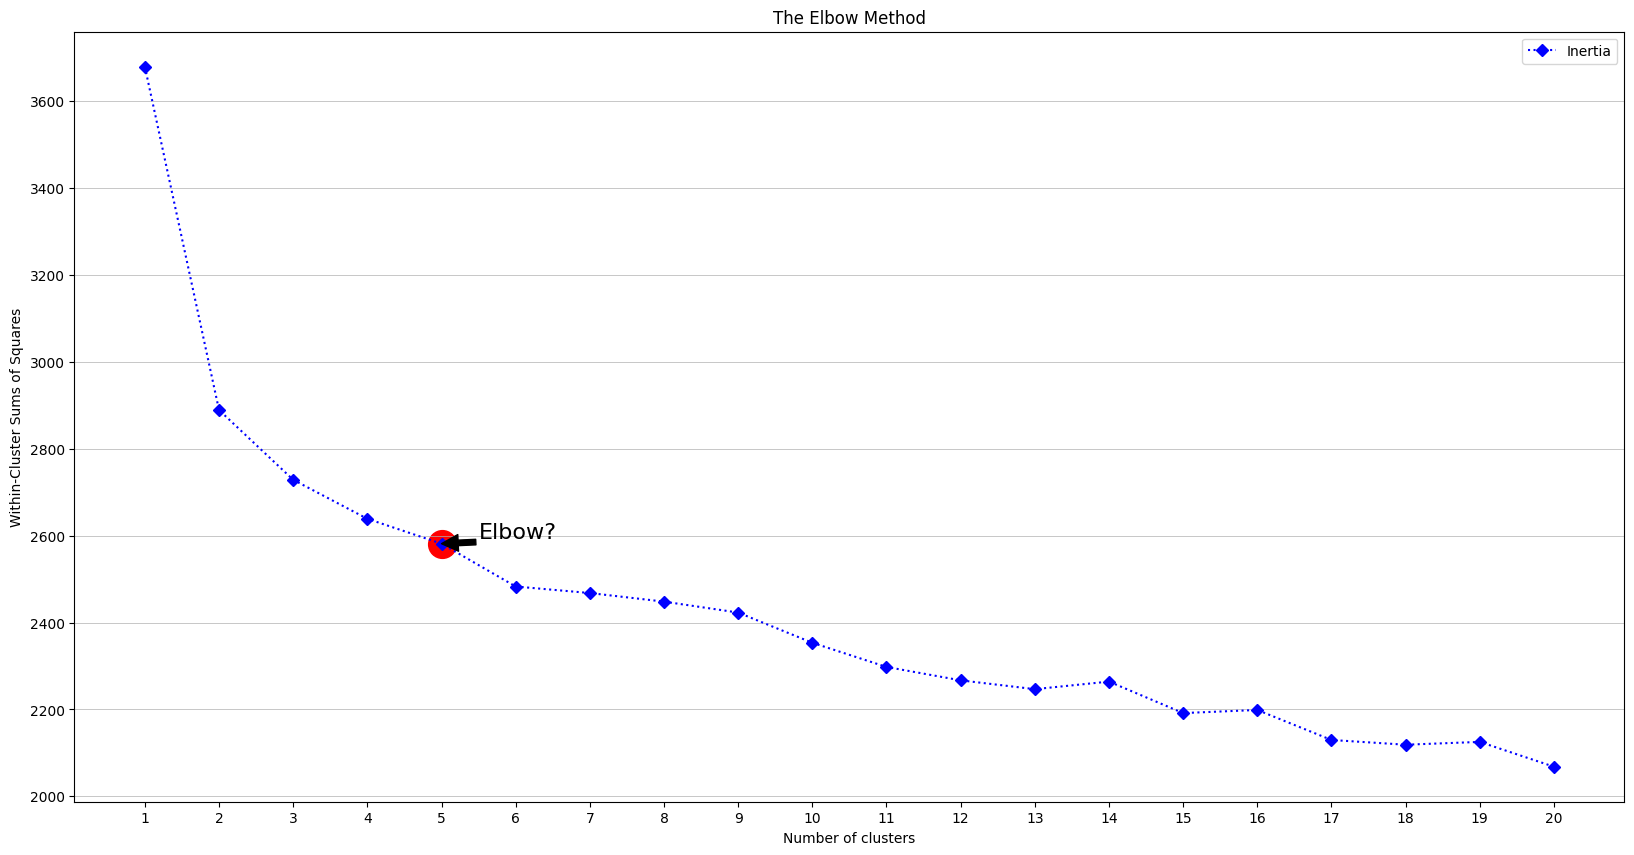

In [64]:
elbow_highlight = 5
with plt.style.context('fast'):
    # figsize
    plt.figure(figsize=(20,10))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(nb_clusters_to_try, wcss,color="blue",linestyle=":",marker="D",label="Inertia")
    # customizing
    ax.legend(loc="upper right")
    ax.set_title('The Elbow Method')
    ax.set_xticks(nb_clusters_to_try)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Within-Cluster Sums of Squares')
    ax.scatter(elbow_highlight,wcss[elbow_highlight-1],c='red',s=400)
    # annotate
    ax.annotate("Elbow?",
                (elbow_highlight,wcss[elbow_highlight-1]),
                (elbow_highlight+0.50,wcss[elbow_highlight-1]+50),
                arrowprops=dict(facecolor='black'),
                fontsize=16,
#                horizontalalignment='middle',
                verticalalignment='top')

    ax.grid(axis="y",linewidth=0.5)
    plt.show()

10 clusters seems to be a reasonnable choice :

In [65]:
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_embeddings_pca)

fig = px.scatter_3d(X_embeddings_pca_df,
                    x = 0,
                    y = 1,
                    z = 2,
                    color=cluster_labels,opacity=0.7, width=500, height=500
           )
fig.show()

In [66]:
df = longest_content_priority_challenges_df.iloc[:number_of_content]
df['Kmean label'] = cluster_labels
for cluster in range(0,10):
    print(f'CLUSTER {cluster}')
    print()
    for index,content in enumerate(df[df['Kmean label'] == cluster]['cleaned text']):
        print(f"    Content {df['id'].iloc[index]}")
        print(f'        {content}')
        print()

CLUSTER 0

    Content 597
        Au même titre que l’ensemble des compétences psychosociales, l’esprit d’initiative s'apprend et favoriser l’estime de soi, l’autonomie et la coopération. Mais comment arriver à former cet esprit d’initiative ? À quel moment l’apprenant arrive-t-il à mettre en œuvre ses savoirs et à se détacher de l’enseignant dans ce triangle traditionnel ? /CUSTOMFRAMEtitle=Voies d'AVENIRlink=Favoriser la réussite et l’insertion des élèves de lycée professionnel grâce aux compétences psychosocialeshref= L’esprit d’initiative, c’est-à-dire ? Nous avons tous connu ces élèves qui, une fois les consignes données, les règles de fonctionnement établies selon les codes du métier appréhendé en formation, restent là, debout devant nous, avec de gros yeux ronds et, des semaines après avoir institué un schéma classique de fonctionnement, nous lâchent le fameux: “Je fais quoi maintenant ? ”. Au regard des retours, lors des visites de PFMP (Période de Formation en Milieu Professi

/var/folders/73/rmpts_0n0r56j1tr5qg14v340000gn/T/ipykernel_29412/1084751722.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
df['Kmean label'].value_counts()

Kmean label
8    58
3    52
2    34
4    32
7    30
9    28
5    21
6    21
1    12
0    12
Name: count, dtype: int64

Next steps:

In [68]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words  # pip install stop-words

# docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
sentences_test = list(longest_content_priority_challenges_df['cleaned text'].iloc[0:300])

french_stopwords = get_stop_words("fr")

vectorizer_model = CountVectorizer(stop_words=french_stopwords)

topic_model = BERTopic(language="french", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(sentences_test)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31,-1_élève_guide_pratique_tsa,"[élève, guide, pratique, tsa, trouble, autisme...",[GUIDE PRATIQUE Scolariser un élève accompagné...
1,0,220,0_élèves_élève_plus_classe,"[élèves, élève, plus, classe, outil, fiche, pr...","[Comment motiver Léo, qui se positionne sur un..."
2,1,35,1_durable_projet_développement_élèves,"[durable, projet, développement, élèves, fiche...",[Les questions relatives au développement dura...
3,2,14,2_stress_émotions_plus_fiche,"[stress, émotions, plus, fiche, outil, activit...",[Dans un précédent article ( nous avions vu q...


In [70]:
topic_model.get_topic(0)

[('élèves', np.float64(0.061833897462334024)),
 ('élève', np.float64(0.030831106805180596)),
 ('plus', np.float64(0.02976863426783423)),
 ('classe', np.float64(0.02966018836422207)),
 ('outil', np.float64(0.029066013934130993)),
 ('fiche', np.float64(0.028573667582665663)),
 ('pratique', np.float64(0.021698258194254222)),
 ('guide', np.float64(0.01967206053593964)),
 ('travail', np.float64(0.01801659646340032)),
 ('temps', np.float64(0.017369421626496784))]

1/ Chunk all contents to 250 token contents to increase content with priority challenge categorisation and benefit from the entire content of the corpus. This should help increasing the accuracy of the supervised model

2/ Interprete the unsupervised Kmean labelling with the help of a decoder like chat GPT


#### Custom Kmean pipeline

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from math import ceil

class TextEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="almanach/camembertav2-base", batch_size=50,max_tokens=250):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.batch_size = batch_size
        self.max_tokens = max_tokens

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        all_embeddings = []
        for start_idx in range(0, len(X), self.batch_size):
            print(f"Embedding batch {round(start_idx/self.batch_size+1)} / {ceil(len(X)/self.batch_size)}")
            batch_texts = X[start_idx:start_idx + self.batch_size]
            inputs = self.tokenizer(batch_texts, padding=True, truncation=True, return_tensors="tf",max_length=self.max_tokens)
            outputs = self.model(**inputs)
            # CLS embedding = first token (<s>)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)
            all_embeddings.append(batch_embeddings.numpy())

        return np.vstack(all_embeddings)


In [72]:
pipeline = Pipeline([
    ("embedder", TextEmbedder(model_name="almanach/camembertav2-base")),
    ("pca", PCA()),
    ("cluster", KMeans(n_clusters=10, random_state=42))
])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2Model: ['embeddings.position_ids']
- This IS expected if you are initializing TFDebertaV2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


In [73]:
sentences_train = list(longest_content_priority_challenges_df['cleaned text'].iloc[:300])
sentences_test = list(longest_content_priority_challenges_df['cleaned text'].iloc[110:111])

labels = pipeline.fit_predict(sentences_train)


Embedding batch 1 / 6
Embedding batch 2 / 6
Embedding batch 3 / 6
Embedding batch 4 / 6
Embedding batch 5 / 6
Embedding batch 6 / 6


In [74]:
df['Kmean label pipeline'] = labels

In [75]:
df['compare labels'] = df['Kmean label'] - df['Kmean label pipeline']

In [76]:
df['Kmean label'].value_counts()

Kmean label
8    58
3    52
2    34
4    32
7    30
9    28
5    21
6    21
1    12
0    12
Name: count, dtype: int64

In [77]:
df['compare labels'].value_counts()

compare labels
0    300
Name: count, dtype: int64

In [78]:
# with open('/content/drive/MyDrive/Colab Notebooks/LeWagon_Project/camembert_model_250.pkl', 'wb') as f:
#      pickle.dump(pipeline, f)

In [80]:
with open('camembert_model_250.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In [81]:
sentences_test = list(longest_content_priority_challenges_df['cleaned text'].iloc[100:111])
loaded_test_labels = loaded_pipeline.predict(sentences_test)
test_labels = pipeline.predict(sentences_test)

Embedding batch 1 / 1
Embedding batch 1 / 1


In [82]:
df_test = pd.DataFrame([sentences_test,test_labels,loaded_test_labels])
df_test

,0,1,2,3,4,5,6,7,8,9,10
0,Lorsque j’ai accueilli pour la première fois d...,Article rédigé dans le cadre d'un partenariat ...,Article rédigé dans le cadre d'un partenariat ...,Article rédigé dans le cadre d'un partenariat ...,L'enseignement de l'anglais en cycle 2 peut pa...,Les réussites demandent persévérance et effort...,"Comme vous, nous avons rencontré dans nos clas...","Et si, en CP, on conjuguait l'apprentissage de...",Le premier signe observable de l'autonomie des...,La dysgraphie est un trouble spécifique de l'a...,Une fois qu’on a identifié les spécificités de...
1,9,6,6,6,4,0,9,5,4,5,2
2,9,6,6,6,4,0,9,5,4,5,2


In [ ]:
# sentences_test = list(longest_content_df['cleaned text'].iloc[:])
# test_labels = pipeline.predict(sentences_test)
# df_test = pd.DataFrame([sentences_test,test_labels])
# df_test

### Fine tuning CAMEMBERT (reducing max token length not to crash)

=> REQUIRES TO MANY RESSOURCES - IT CRASHES OR DOES NOT CONVERGE AFTER 1 NIGHT ON COLAB

In [ ]:
# from transformers import TFAutoModelForSequenceClassification
# embedded_contents = tokenizer(longest_content_priority_challenges_df['cleaned text'].tolist(),is_split_into_words=False,return_tensors='tf',padding=True, truncation=True,max_length=200)
# X = embedded_contents['input_ids'][:number_of_content].numpy()
# y = longest_content_priority_challenges_df[['transition_ecologique','sante_mentale','ecole_inclusive','cps','reussite_tous_eleves']].iloc[:number_of_content]
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# X_train.shape

(240, 200)

In [ ]:
# es = EarlyStopping(patience = 20, restore_best_weights=True)
# optimizer = Adam(
#     learning_rate=0.0002,
#     beta_1=0.90,
#     beta_2=0.999,
#     epsilon=1e-07,
# )

# fast_model=TFAutoModelForSequenceClassification.from_pretrained("almanach/camembertav2-base",from_pt=True,num_labels=5)
# fast_model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
# fast_model.fit(X_train,y_train,validation_split=0.2, batch_size=1, epochs=1000, callbacks=es)